# Hybrid Quantum Neural Networks 

The example below highlights a hybrid quantum neural network workflow with CUDA Quantum and Pytorch where both layers are GPU accelerated to maximise performance. 

<!-- ![hybrid](hybrid.png) -->

<img src="hybrid.png" alt="hybrid" width="600">



We perform binary classification on the MNIST dataset where data flows through the neural network architecture to the quantum circuit whose output is used to classify hand written digits.

In [1]:
#Import the relevant packages 

import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

In [2]:
# GPU utilities 

cudaq.set_target('nvidia')  #Set CUDAQ to run on GPUs 

torch.cuda.is_available() #If this is True then the NVIDIA drivers are correctly installed 

torch.cuda.device_count() #Counts the number of GPUs available 

torch.cuda.current_device()

torch.cuda.get_device_name(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [3]:
# Training set 
n_samples = 140

X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

#Test set 
n_samples = 70

X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)


In [4]:
class QuantumCircuit:
    '''This class defines the quantum circuit structure and the run method which is used to calculate an expectation value'''
    
    def __init__(self, n_qubits: int):
        
        '''Define the quantum circuit in CUDA Quantum'''

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel 
        
        self.theta = thetas 

        qubits = kernel.qalloc(n_qubits)

        self.kernel.h(qubits)

        #Variational gate parameters which are optimised during training 
        kernel.ry(thetas[0], qubits[0])
        kernel.rx(thetas[1], qubits[0])

    
    def run(self, thetas: torch.tensor) -> torch.tensor:
        
        '''Excetute the quantum circuit to output an expectation value'''

        expectation = torch.tensor(cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z(), device = device)

        return expectation
    


In [5]:
class QuantumFunction(Function):
    
    '''Allows the quantum circuit to pass data through it and compute the gradients '''
    
    
    @staticmethod  
    def forward(ctx, thetas: torch.tensor, quantum_circuit, shift) -> torch.tensor: 
        
        #save shift and quantum_circuit in context to use in backward 
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        #calculate exp_val 
        expectation_z = ctx.quantum_circuit.run(thetas)
                
        ctx.save_for_backward(thetas, expectation_z)

        return expectation_z
        
        
    @staticmethod
    def backward(ctx, grad_output):
        
        """ Backward pass computation via finite difference parameter shift"""
        
        thetas, expectation_z = ctx.saved_tensors
        
        gradients = torch.zeros(len(thetas), device = device)
                
        for i in range(len(thetas)):

            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift
            
            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift
            
            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5*(expectation_right - expectation_left)
            
        return gradients * grad_output.float(), None, None



In [6]:
class QuantumLayer(nn.Module):
    '''Encapsulates a quantum circuit and a quantum function into a quantum layer'''
    
    def __init__(self, shift: torch.tensor):
        
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(1)  #1 qubit quantum circuit 
        self.shift = shift
        
    def forward(self, input):
        
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return ans

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #Neural network structure 
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2) #Output a 2D tensor since we have 2 variational parameters in our quantum circuit 
        self.hybrid = QuantumLayer(torch.tensor(np.pi/2)) #Input is the magnitude of the parameter shifts to calculate gradients 


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).reshape(-1) #Reshapes required to satisfy input dimensions to CUDAQ         
        x = self.hybrid(x).reshape(-1)
        
        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [8]:
#We move our model to the CUDA device to minimise data transfer between GPU and CPU

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

          
model.train()
for epoch in range(epochs):
    
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader): #batch training 
                        
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data).to(device)
            
        # Calculating loss
        loss = loss_func(output, target).to(device)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        batch_loss += loss.item()
        
    epoch_loss.append(batch_loss/batch_idx)
    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, epoch_loss[-1]))

Training [5%]	Loss: -1.1225
Training [10%]	Loss: -1.3629
Training [15%]	Loss: -1.4055
Training [20%]	Loss: -1.4119
Training [25%]	Loss: -1.4319
Training [30%]	Loss: -1.4349
Training [35%]	Loss: -1.4480
Training [40%]	Loss: -1.4627
Training [45%]	Loss: -1.4507
Training [50%]	Loss: -1.4767
Training [55%]	Loss: -1.4820
Training [60%]	Loss: -1.4763
Training [65%]	Loss: -1.4740
Training [70%]	Loss: -1.4798
Training [75%]	Loss: -1.4787
Training [80%]	Loss: -1.4847
Training [85%]	Loss: -1.4918
Training [90%]	Loss: -1.4913
Training [95%]	Loss: -1.4897
Training [100%]	Loss: -1.4900


Text(0, 0.5, 'Neg Log Likelihood Loss')

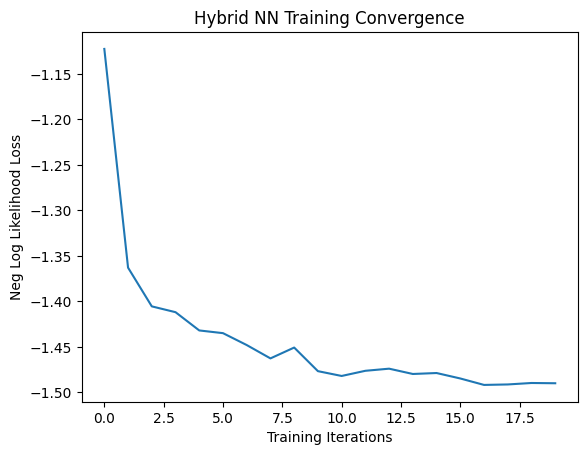

In [9]:
plt.plot(epoch_loss)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')

plt.ylabel('Neg Log Likelihood Loss')

In [10]:
#Testing on the test set 

model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        epoch_loss.append(loss.item())
        
    print('Performance on test data:\n\tAccuracy: {:.1f}%'.format(correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 100.0%


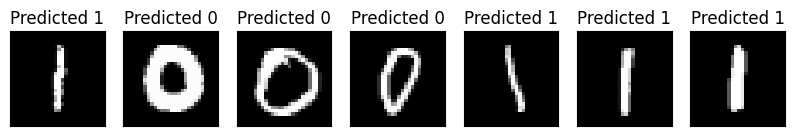

In [11]:
#Show test set samples 

n_samples_show = 7
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)
        
        pred = output.argmax(dim=1, keepdim=True)
        
        data = data.cpu()

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1